# Regularized Regression Assignment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load data
boston = pd.read_csv('/content/drive/MyDrive/Dibimbing/Day 16 - Regularized Regression in Python/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# 1. Split Data: Train - Validate - Test

In [4]:
# split train validate test
from sklearn.model_selection import train_test_split

feature = boston.drop(columns='medv')
target = boston[['medv']]

feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_boston_train, feature_boston_validation, target_boston_train, target_boston_validation = train_test_split(feature_boston_pretrain, target_boston_pretrain, test_size=0.20, random_state=42)

# 2. Draw correlation plot on training data and perform feature selection on highly correlated features

In [5]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


There are several features with high VIF scores:
1. `nox`
2. `dis`
3. `rad`
4. `tax`

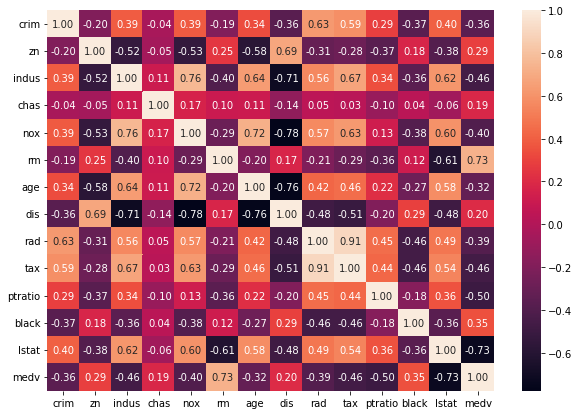

In [6]:
# heatmap correlation
boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

There are two features high correlated each other: `rad` and `tax`. We choose to retain `tax`. Therefore, we need to drop:
* `rad`

In [7]:
# drop redundant feature
feature_boston_train = feature_boston_train.drop(columns=['rad'])
feature_boston_validation = feature_boston_validation.drop(columns=['rad'])
feature_boston_test = feature_boston_test.drop(columns=['rad'])

# 3. Fit models on training data (lambdas = [0.01, 0.1, 1, 10])

## a. Ridge Regression

In [8]:
from sklearn.linear_model import Ridge

# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_boston_train, y_boston_train)
ridge_reg_pointone.fit(X_boston_train, y_boston_train)
ridge_reg_one.fit(X_boston_train, y_boston_train)
ridge_reg_ten.fit(X_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

## b. LASSO

In [9]:
from sklearn.linear_model import Lasso

# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_boston_train, y_boston_train)
lasso_reg_pointone.fit(X_boston_train, y_boston_train)
lasso_reg_one.fit(X_boston_train, y_boston_train)
lasso_reg_ten.fit(X_boston_train, y_boston_train)

Lasso(alpha=10, random_state=42)

# 4. Choose the best lambda from the validation set

## a. Use RMSE as metric


### Ridge

In [10]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.960676932957843
RMSE of Ridge regression model with alpha = 0.1 is 4.949412535122791
RMSE of Ridge regression model with alpha = 1.0 is 4.912351371579991
RMSE of Ridge regression model with alpha = 10 is 4.871717983886228


Best lambda/alpha for ridge model is 10

### Lasso

In [11]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 4.934105658639752
RMSE of Lasso regression model with alpha = 0.1 is 4.907145314259478
RMSE of Lasso regression model with alpha = 1.0 is 4.845855910636398
RMSE of Lasso regression model with alpha = 10 is 5.426622694252769


Best lambda/alpha for lasso model is 1

## b. Interpret a sample of the coefficients of the best model

### Ridge

In [12]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


`medv` = 15.064 + (-0.071) `crim` + 0.033 `zn` + (-0.067) `indus` + 1.955 `chas` + (-1.568) `nox` + 4.783 `rm` + (-0.011) `age` + (-1.260) `dis` + (-0.001) `tax` + (-0.697) `ptratio` + 0.012 `black` + (-0.523) `lstat` 

Interpretation = An increase of 1 point in `rm` (number rooms average), while the other features are kept fixed, is associated with an increase of 4.783 in `medv` (housing price)

### Lasso

In [13]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


`medv` = 25.823 + (-0.041) `crim` + 0.025 `zn` + 2.504 `rm` + 0.022 `age` + (-0.599) `dis` + (-0.002) `tax` + (-0.666) `ptratio` + 0.011 `black` + (-0.712) `lstat` 

Interpretation = An increase of 1 point in `rm` (number rooms average), while the other features are kept fixed, is associated with an increase of 2.504 in `medv` (housing price)

# Diagnostic Study

Not Mandatory

## Ridge

In [14]:
from sklearn.metrics import r2_score

y_predict_train_ridge = ridge_best.predict(X_boston_train)

print('R-squared for training data with ridge model is {}'.format(r2_score(y_boston_train, y_predict_train_ridge)))

R-squared for training data with ridge model is 0.748587526366982


Interpretation: 74.85% of variability of `medv` is successfully explained
using all the features in the model

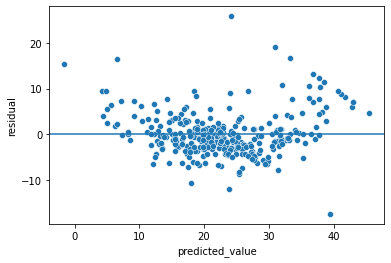

In [15]:
# calculate residuals
residual = y_boston_train - y_predict_train_ridge

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_ridge,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

## Lasso

In [16]:
from sklearn.metrics import r2_score

y_predict_train_lasso = lasso_best.predict(X_boston_train)

print('R-squared for training data with lasso model is {}'.format(r2_score(y_boston_train, y_predict_train_lasso)))

R-squared for training data with lasso model is 0.7056815963218595


Interpretation: 70.56% of variability of `medv` is successfully explained
using all the features in the model

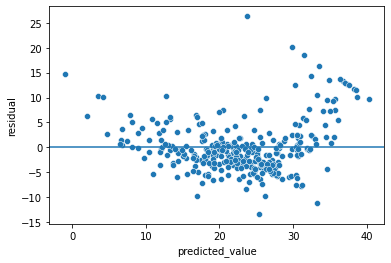

In [17]:
# calculate residuals
residual = y_boston_train - y_predict_train_lasso

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_lasso,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

# 5. Evaluate the best models on the test data

## a. Ridge

### Training Error

In [18]:
# prepare prediction result on train data
y_predict_train_ridge = ridge_best.predict(X_boston_train)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_boston_train, y_predict_train_ridge))))
print('MAE for training data is {}'.format(mean_absolute_error(y_boston_train, y_predict_train_ridge)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_boston_train, y_predict_train_ridge)))

RMSE for training data is 4.778640361040111
MAE for training data is 3.3776762058865626
MAPE for training data is 0.16868073663359498


### Testing Error

In [20]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test_ridge = ridge_best.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_boston_test, y_predict_test_ridge))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_boston_test, y_predict_test_ridge)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_boston_test, y_predict_test_ridge)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.2444816457044965
MAPE for testing data is 0.17618402626767926


Interpretation:
* RMSE: The standard deviation of
prediction errors is 5.158 i.e. from the regression
line, the residuals mostly
deviate between +- 5.158
* MAE: On average, our prediction 
deviates the true `medv` by 3.244
* MAPE: Moreover, this 3.244 is 
equivalent to 17.61% 
deviation relative to the 
true `medv`

## Lasso

### Training Error

In [22]:
# prepare prediction result on training data
y_predict_train_lasso = lasso_best.predict(X_boston_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_boston_train, y_predict_train_lasso))))
print('MAE for training data is {}'.format(mean_absolute_error(y_boston_train, y_predict_train_lasso)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_boston_train, y_predict_train_lasso)))

RMSE for training data is 5.170346463296143
MAE for training data is 3.6858416211465084
MAPE for training data is 0.1749128202363825


### Testing Error

In [23]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test_lasso = lasso_best.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [24]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_boston_test, y_predict_test_lasso))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_boston_test, y_predict_test_lasso)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_boston_test, y_predict_test_lasso)))

RMSE for testing data is 5.125494212319777
MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.17856606338732206


Interpretation:
* RMSE: The standard deviation of
prediction errors is 5.125 i.e. from the regression
line, the residuals mostly
deviate between +- 5.125
* MAE: On average, our prediction 
deviates the true `medv` by 3.398
* MAPE: Moreover, this 3.398 is 
equivalent to 17.85% 
deviation relative to the 
true `medv`

**Last Interpretation: Based on comparison of RMSE, MAE, and MAPE between training data and testing data, Both Ridge and Lasso model not underfitting or overfitting. They both are just right or acceptable.**